In [ ]:
import sys
import networkx as nx
import numpy as np
import numpy.typing as npt
import pandapower as pp

from itertools import combinations
from dimod import ConstrainedQuadraticModel, Real, quicksum, Binary

# Building up a network of prosumers and an external grid

In [4]:
import pandapower as pp
import networkx as nx
import random
import matplotlib.pyplot as plt

def generate_er_graph(num_nodes, probability):
    # Generate a random graph using NetworkX
    random_graph = nx.erdos_renyi_graph(num_nodes, probability)

    # Create an empty network
    net = pp.create_empty_network()

    # Add buses to the network
    for node in random_graph.nodes:
        pp.create_bus(net, name=f"Bus {node}", vn_kv=0.4)

    # Add lines to the network based on the random graph edges
    for edge in random_graph.edges:
        pp.create_line(net, from_bus=edge[0], to_bus=edge[1], length_km=1, std_type="NAYY 4x150 SE")

    # Determine the number of prosumer nodes (both load and generation)
    num_prosumers = int(0.9 * num_nodes)
    prosumer_nodes = random.sample(random_graph.nodes, num_prosumers)
    if 0 in prosumer_nodes:
        prosumer_nodes.remove(0)
    # Add prosumers to the network
    for node in prosumer_nodes:
        pp.create_sgen(net, bus=node, p_mw=50, q_mvar=-25, sn_mva=0.1)  # Example generator
        pp.create_load(net, bus=node, p_mw=100, q_mvar=50)  # Example load

    # Randomly assign the remaining nodes as either loads or generators
    remaining_nodes = list(set(random_graph.nodes) - set(prosumer_nodes))
    for node in remaining_nodes:
        if random.choice([True, False]):
            pp.create_load(net, bus=node, p_mw=100, q_mvar=50)  # Example load
        else:
            pp.create_sgen(net, bus=node, p_mw=50, q_mvar=-25, sn_mva=0.1)  # Example generator

    # Add external grid to the network
    ext_grid_bus =0# random.choice(list(net.bus.index))
    pp.create_ext_grid(net, bus=ext_grid_bus, vm_pu=1.0, va_degree=0.0, s_sc_max_mva=1000.0)
    connected_buses = nx.node_connected_component(random_graph, ext_grid_bus)
    print('connected_buses',connected_buses)
    if len(connected_buses) == 1:
    # Select a random bus from the remaining nodes and connect it to the external grid
        connected_bus = random.choice(remaining_nodes)
        pp.create_line(net, from_bus=ext_grid_bus, to_bus=connected_bus, length_km=1, std_type="NAYY 4x150 SE")
    
    pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True)

    
    plt.show()
    return(net,prosumer_nodes)



   

## Creation of optimization models



### Separate models for each individual customer

$$
\begin{align}
  \min_{p_i} & \quad c_i(p_i) - \Delta_t \sum_{t \in [T]} \left(\lambda_t^b [p_{it}]^- + \lambda_t^s [p_{it}]^+ \right), \\
  \textrm{s.t.} & \quad p_i \in \mathcal{P}_i.
\end{align}
$$

### Net-metered energy model

$$
\begin{align}
  \min_{p_i, i \in [N]} & \quad \sum_{i \in [N]} c_i(p_i) - \Delta_t \sum_{t \in [T]} (\lambda_t^b [\sum_{i \in [N]}p_{it}]^- + \lambda_t^s [\sum_{i \in [N]}p_{it}]^+ ), \\
  \textrm{s.t.} & \quad p_i \in \mathcal{P}_i, \forall i \in [N].
\end{align}
$$

In [5]:
def build_consumption_model(consumptions: npt.NDArray, coalition: tuple,
                            prices_buy: npt.NDArray, prices_sell: npt.NDArray,
                            flexibility=0.5, delta_t=0.25,
                            lower_bound=-50, upper_bound=50):
   
    print(coalition)

    cqm = ConstrainedQuadraticModel()
    

    p_vars = []
    p_vars_sum = []
    
    costs_of_use = []

    n_prosumers, n_timesteps = consumptions.shape

    if isinstance(flexibility, float) or isinstance(flexibility, int):
        flexibility = [flexibility] * n_prosumers

    if len(flexibility) < n_prosumers:
        raise ValueError(f"Cannot map flexibilities: {len(flexibility)} flexibilities "
                         f"cannot be mapped to {n_prosumers} prosumers")

    for i in coalition:
        p_vars_i = []
        consumption = consumptions[i, :n_timesteps]

        for t, _ in enumerate(consumption):

            p_var = Real(f"p_{i}_{t}", lower_bound=lower_bound, upper_bound=upper_bound)
            p_vars_i.append(p_var)
            

            

            if consumption[t] >= 0:
                # Prosumer or consumer
                if i in prosumer_nodes:
                   
                    cqm.add_constraint_from_model(p_var,'>=',-consumption[t] * (1 + flexibility[i]),
                                                label=f"p_var_{i}_{t} ge -consumed_{i}_{t} * (1 + flex)")
                    cqm.add_constraint_from_model(p_var, '<=', consumption[t] * (1 + flexibility[i]),
                                                label=f"p_var_{i}_{t} le consumed_{i}_{t} * (1 + flex)")
                else:
                    cqm.add_constraint_from_model(p_var, '>=', 0,
                                              label=f"p_var_{i}_{t} ge 0")
                    cqm.add_constraint_from_model(p_var, '<=', consumption[t] * (1 + flexibility[i]),
                                              label=f"p_var_{i}_{t} le consumed_{i}_{t} + flex")
            else:
                if i in prosumer_nodes:
                #  Prosumer or Producer
                    cqm.add_constraint_from_model(p_var, '>=', consumption[t] * (1 + flexibility[i]),
                                              label=f"p_var_{i}_{t} ge produced_{i}_{t} + flex")
                    cqm.add_constraint_from_model(p_var, '<=', -consumption[t] * (1 + flexibility[i]),
                                                label=f"p_var_{i}_{t} le -consumed_{i}_{t} * (1 + flex)")
               
                
                else:
                    
                    
                    cqm.add_constraint_from_model(p_var, '>=', consumption[t] * (1 + flexibility[i]),
                                            label=f"p_var_{i}_{t} ge produced_{i}_{t} + flex")
                    
                    cqm.add_constraint_from_model(p_var, '<=', 0,
                                            label=f"p_var_{i}_{t} le 0")

        

           

        p_vars.append(p_vars_i)
        # z_vars.append(z_vars_i)

        p_vars_sum.append(quicksum(p_vars_i))
        costs_of_use.append(quicksum(p_vars_i))
    
    z_vars = []    
    sumP_vars = []    
    
    for t, _ in enumerate(consumption):
        
        z_var = Binary(f"z_{t}")
        sumP = quicksum(p[t] for p in p_vars)
        
        
        cqm.add_constraint_from_model(sumP * (2 * z_var - 1), '>=', 0)
        
        z_vars.append(z_var)
        sumP_vars.append(sumP)
    
    total_consumption = consumptions[coalition, :].sum()
    
    
 
   
    cqm.add_constraint_from_model(quicksum(p_vars_sum), '==', total_consumption,
                                  label="sum(p_vars) == total_consumption")
    
    

    objective = quicksum(costs_of_use) + delta_t * quicksum(
        buy_price * sumP_var * z_var + sell_price * sumP_var * (1 - z_var) 
        for (buy_price, sell_price, sumP_var, z_var)
        in zip(prices_buy, prices_sell, sumP_vars, z_vars) 
    )

    cqm.set_objective(objective)

    return cqm

In [7]:
import ray
ray.init(num_cpus=32)

2023-11-17 12:14:56,144	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.8.17
Ray version:,2.5.1


In [ ]:
n

In [ ]:
n_prosumers =18
n_timesteps = 4
t_offset = 30
with_pv_ratio = 0.5
delta_t = 0.25

grid_data = get_grid_data(200)
_consumption = (grid_data.raw_consumption[:, t_offset:t_offset + n_timesteps]
                - grid_data.pv[:, t_offset:t_offset + n_timesteps])
co2_intensity = grid_data.co2_intensity[t_offset:t_offset + n_timesteps]


upper_bound = (grid_data.raw_consumption - grid_data.pv).max() * 5
lower_bound = (grid_data.raw_consumption - grid_data.pv).min() * 5


@ray.remote
def run(ii):
    global w_solutions
    dimod.REAL_INTERACTIONS=True
   
    np.random.seed(ii+5+7)
    
    idx_prod = np.where((_consumption < 0))[0]
    idx_cons = np.where((_consumption > 0))[0]
    idx_prod = np.random.choice(
        idx_prod,
        size=int(with_pv_ratio * n_prosumers),
        replace=True,
    )
    idx_cons1 = np.random.choice(
        idx_cons, size=n_prosumers - idx_prod.size, replace=True
    )

    while np.abs(_consumption[idx_prod].sum() + _consumption[idx_cons1].sum()) > 5:
        idx_cons1 = np.random.choice(
            idx_cons, size=n_prosumers - idx_prod.size, replace=True
        )

    prosumer_consumptions = np.vstack([_consumption[idx_prod], _consumption[idx_cons1]])

    grid_co2_norm = co2_intensity / co2_intensity.max()
    prices_sell = grid_co2_norm - 0.25
    prices_buy = grid_co2_norm + 0.25

    coalitions = [tuple(sorted(combo))
                  for i in range(1, n_prosumers + 1)
                  for combo in combinations(range(n_prosumers), i)]

    
    flexibility = 0.8

    models = {
        coalition: build_consumption_model(prosumer_consumptions, coalition,
                                           flexibility=flexibility,
                                           prices_buy=prices_buy,
                                           prices_sell=prices_sell,
                                           delta_t=delta_t,
                                           lower_bound=lower_bound,
                                           upper_bound=upper_bound)
        for coalition in coalitions
    }
    solution_params = {coalition: solve("gurobi", models[coalition], quiet=True).first
                       for coalition in coalitions}

    individual_solutions = np.vstack(
        [[solution_params[(agent,)].sample[f"p_{agent}_{timestep}"]
          for timestep in range(n_timesteps)]
         for agent in range(n_prosumers)]
    )

    net_solutions = {}

    for coalition in coalitions:
        net_solutions[coalition] = individual_solutions.copy()
    
        for agent in coalition:
            net_solutions[coalition][agent, :] = [
                solution_params[coalition].sample[f"p_{agent}_{timestep}"]
                for timestep in range(n_timesteps)
            ]

    optimized_individual = powerflow_optimization(individual_solutions,
                                                  prices_buy=prices_buy,
                                                  prices_sell=prices_sell,
                                                  delta_t=delta_t)
    coalition_values = {coalition: optimized_individual
                                   - powerflow_optimization(net_solutions[coalition],
                                                            prices_buy=prices_buy,
                                                            prices_sell=prices_sell,
                                                            delta_t=delta_t)
                        for coalition in coalitions}
   
    # coalition_values={(0,): 0.0, (1,): 0.0, (2,): 0.0, (0, 1): -1,
    #                   (0, 2): 2, (1, 2): -0.5, (0, 1, 2): 0.5}
    opf_model = isg_minimization(coalition_values)
    w_solutions = solve("gurobi", opf_model, quiet=True).first
    #print('w_solutions',w_solutions)

    weights = {(i, j): w_solutions.sample[f"w_{i}_{j}"]
               for i in range(n_prosumers)
               for j in range(n_prosumers)
               if i < j and  abs(w_solutions.sample[f"w_{i}_{j}"]) >= 0.0001}
    #print('weights',weights)
    
    return weights

In [8]:
# def go_to_optimized_step(solution, timestep):
#     global net

#     flexibility_pd = 0.1
#     pp.drop_elements(net, "sgen", net.sgen.index)

#     net.line["max_loading_percent"] = 100
#     net.bus["max_vm_pu"] = 1.05
#     net.bus["min_vm_pu"] = 0.95

#     for  load in net.load.itertuples():
#         if load.bus == 0:
#             continue
#         net.load.at[load.Index, "q_mvar"] = 0

#         if solution[load.bus-1, timestep] < 0:
#             net.load.at[load.Index, "p_mw"] = 0

#             pp.create_sgen(net, bus=load.bus,
#                            p_mw=-solution[load.bus-1, timestep] / 1000,
#                            min_p_mw=0,
#                            max_p_mw=-solution[load.bus-1, timestep] * (1 + flexibility_pd) / 1000,
#                            min_q_mvar=0,
#                            max_q_mvar=1,
#                            controllable=False)
#         else:
#             net.load.at[load.Index, "p_mw"] = solution[load.bus-1, timestep] / 1000
#             net.load.at[load.Index, "controllable"] = False

In [10]:
def go_to_optimized_step(solution, timestep):
    global net

    flexibility_pd = 0.1
    pp.drop_elements(net, "sgen", net.sgen.index)

    net.line["max_loading_percent"] = 100
    net.bus["max_vm_pu"] = 1.05
    net.bus["min_vm_pu"] = 0.95

    for load_idx, load in net.load.iterrows():
        net.load.at[load_idx, "q_mvar"] = 0

        if solution[load_idx, timestep] < 0:
            net.load.at[load_idx, "p_mw"] = 0

            pp.create_sgen(net, bus=load.bus,
                           p_mw=-solution[load_idx, timestep] / 1000,
                           min_p_mw=0,
                           max_p_mw=-solution[load_idx, timestep] * (1 + flexibility_pd) / 1000,
                           min_q_mvar=0,
                           max_q_mvar=1,
                           controllable=False)
        else:
            net.load.at[load_idx, "p_mw"] = solution[load_idx, timestep] / 1000
            net.load.at[load_idx, "controllable"] = False

In [11]:
def set_cost(buy_price, sell_price):
    global net

    # Removing any existing piece-wise linear (pwl) cost
    pp.toolbox.drop_elements(net, "pwl_cost", net.pwl_cost.index)

    # Assign cost to external grid such that we have different prices for consumption (>0) and for generation (<0)
    ext_grid_idx = 0
    min_power_to_consider_mw = -100
    max_power_to_consider_mw = 100
    pp.create_pwl_cost(net, ext_grid_idx, "ext_grid", [[min_power_to_consider_mw, 0, sell_price],
                                                       [0, max_power_to_consider_mw, buy_price]])

In [12]:
def powerflow_optimization(prosumer_powers, prices_buy, prices_sell, delta_t=0.25):
    global net

    result_costs = []
    n_prosumers, n_timesteps = prosumer_powers.shape

    for timestep in range(n_timesteps):
        lambda_b = prices_buy[timestep] * 1000
        lambda_s = prices_sell[timestep] * 1000

        set_cost(buy_price=lambda_b,
                 sell_price=lambda_s)

        # Set parameters of the grid to correspond to timestep
        go_to_optimized_step(solution=prosumer_powers, timestep=timestep)

        # Run DC optimal power flow problem
        pp.rundcopp(net)
        
        power_out = net.res_ext_grid["p_mw"][0]
        if power_out > 0:
            result_costs.append(delta_t * power_out * lambda_b)
        else:
            result_costs.append(delta_t * power_out * lambda_s)

    return sum(result_costs)

In [13]:

def isg_minimization(coalition_values):
    cqm = ConstrainedQuadraticModel()

    weights = {edge: Real(label=f"w_{edge[0]}_{edge[1]}",lower_bound=-50, upper_bound=50)
               for edge in combinations(range(n_prosumers), 2)}
    
    isg_objective = 0
    for coalition, value in coalition_values.items():
        #print('coalition',coalition)
        #print('value',value)
        edges = combinations(coalition, 2)
        #print('edges',[item for item in edges])
        isg_objective += (coalition_values[coalition] - quicksum(weights[edge] for edge in edges))**2
        #print(isg_objective)
    cqm.set_objective(isg_objective)
    return cqm
    
    
    

In [ ]:
%%time
edge_weights_list=[]
import dimod



prosumers_node_list=[]
num_nodes = n_prosumers# +1 is for an external grid
probabilities = 0.01#[0.05,0.1,0.3,0.4,0.4,0.6,0.8,0.9]
net_list=[]
np.random.seed(num_nodes)
for probability in probabilities:
    net,nodes=generate_er_graph(num_nodes, probability)
    #net,nodes=(np.load('edge_weights_n=16_t=4_Pr_9_25_samples.npy', allow_pickle=True).item()['net']),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#generate_er_graph(num_nodes, probability)
    #net,nodes=np.load('edge_weights_n=16_t=4_Pr_7_20_samples.npy', allow_pickle=True).item()['net'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]#generate_er_graph(num_nodes, probability)
    net_list.append(net)
    prosumers_node_list.append(nodes)
    
    

for ii in range(10):
    print('ii',ii)
   #for iii,net in enumerate(net_list):
    #print('hi')
    prosumer_nodes=prosumers_node_list[0]
    n_prosumers = len(net.bus)
    print('n_prosumers',n_prosumers)
    w= run.remote(ii)
    print('w',w)
    edge_weights_list.append(w)
edge_weights_list_f=ray.get(edge_weights_list)    
    

ii 0
n_prosumers 16
w ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000)
ii 1
n_prosumers 16
w ObjectRef(16310a0f0a45af5cffffffffffffffffffffffff0100000001000000)
ii 2
n_prosumers 16
w ObjectRef(c2668a65bda616c1ffffffffffffffffffffffff0100000001000000)
ii 3
n_prosumers 16
w ObjectRef(32d950ec0ccf9d2affffffffffffffffffffffff0100000001000000)
ii 4
n_prosumers 16
w ObjectRef(e0dc174c83599034ffffffffffffffffffffffff0100000001000000)
ii 5
n_prosumers 16
w ObjectRef(f4402ec78d3a2607ffffffffffffffffffffffff0100000001000000)
ii 6
n_prosumers 16
w ObjectRef(f91b78d7db9a6593ffffffffffffffffffffffff0100000001000000)
ii 7
n_prosumers 16
w ObjectRef(82891771158d68c1ffffffffffffffffffffffff0100000001000000)
ii 8
n_prosumers 16
w ObjectRef(8849b62d89cb30f9ffffffffffffffffffffffff0100000001000000)
ii 9
n_prosumers 16
w ObjectRef(80e22aed7718a125ffffffffffffffffffffffff0100000001000000)


# ISG graphs

### The graphs generated after transfering CFG to ISG. The upper graph shows the network of 12 prosumers and one external grid and the lower ones show the generated ISG graphs. 

# N=12

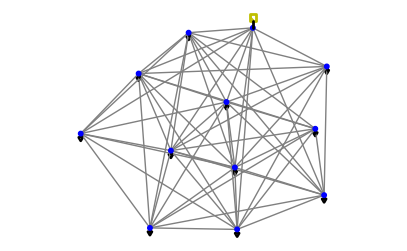

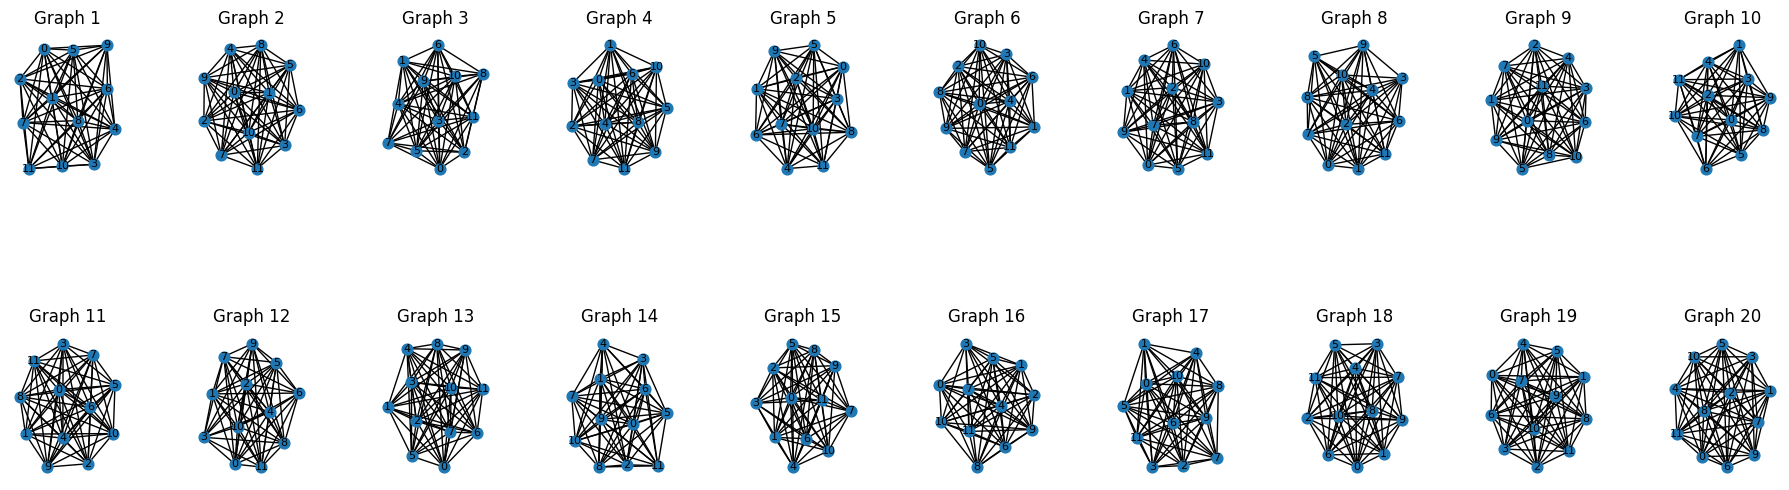

In [98]:
# num_nodes=8 probability =0.7
fig, ax = plt.subplots(figsize=(5, 3))
pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, ax=ax)

plt.show()
 
empty_graph_list=[]
for _ in range(len(edge_weights_list_f)):
    empty_graph = nx.Graph()
    empty_graph_list.append(empty_graph)
num_rows = 2
num_cols =10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5))  # Adjust the figsize as needed

for i, ax in enumerate(axes.flat):
    
        graph = empty_graph_list[i]
        graph.add_edges_from(edge_weights_list_f[i])
        nx.draw(graph, ax=ax, with_labels=True,node_size=60, font_size=8)  # Customize the drawing options as needed
        ax.set_title(f"Graph {i+1}")

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=1) 

# Show the plots
plt.show()

# N=10

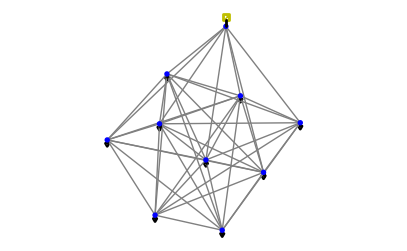

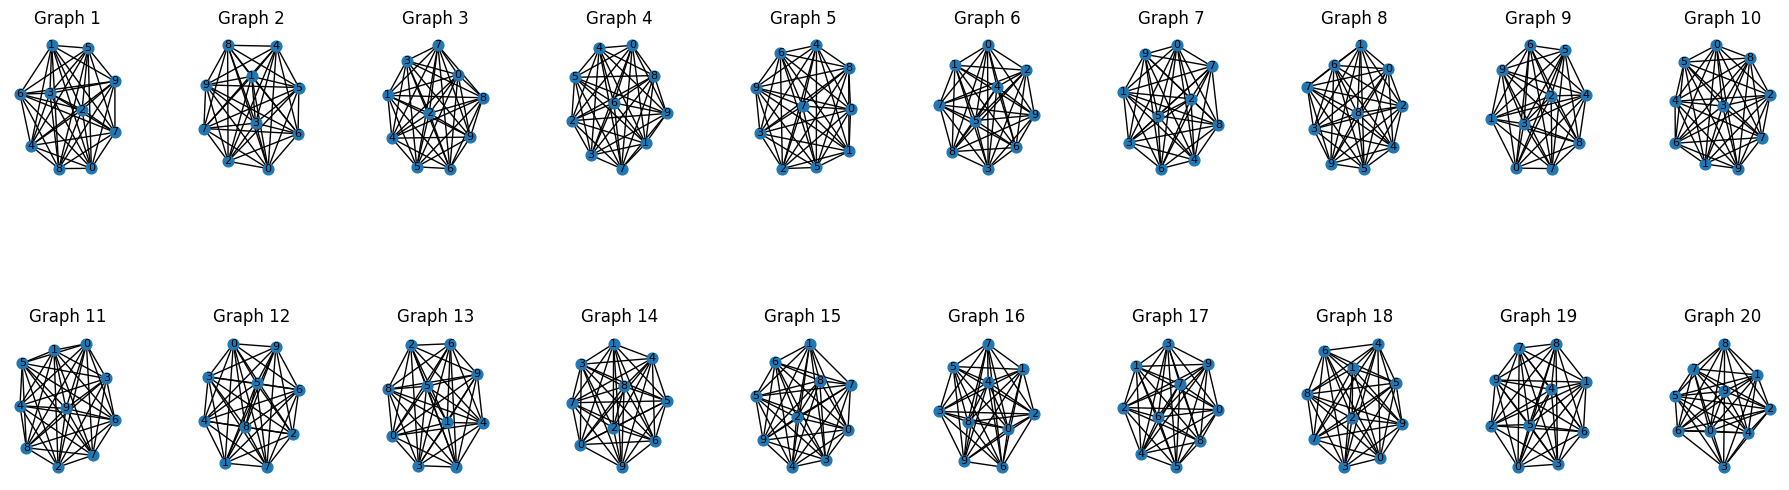

In [74]:
# num_nodes=8 probability =0.7
fig, ax = plt.subplots(figsize=(5, 3))

# Call the simple_plot function to plot the network on the specified axes
pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, ax=ax)

#fig, ax = pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, figsize=(8, 6))

# Show the plot
plt.show()
 
empty_graph_list=[]
for _ in range(len(edge_weights_list_f)):
    empty_graph = nx.Graph()
    empty_graph_list.append(empty_graph)
num_rows = 2
num_cols =10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5))  # Adjust the figsize as needed

for i, ax in enumerate(axes.flat):
    
        graph = empty_graph_list[i]
        graph.add_edges_from(edge_weights_list_f[i])
        nx.draw(graph, ax=ax, with_labels=True,node_size=60, font_size=8)  # Customize the drawing options as needed
        ax.set_title(f"Graph {i+1}")

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.6, hspace=1) 

# Show the plots
plt.show()

# Calculating the density of the graph

In [2]:
import numpy as np
def calculate_density(graph):
    # Count the number of edges in the graph
    num_edges = len(graph)
    
    # Calculate the number of possible edges based on the number of nodes
    num_nodes = max(max(edge) for edge in graph.keys()) + 1
    num_possible_edges = (num_nodes * (num_nodes - 1)) / 2
    
    # Calculate the density
    density = num_edges / num_possible_edges
    
    return density
density=[]
x2=np.load('edge_weights_n=18_t=4_Pr_9_5_samples_3.npy', allow_pickle=True).item()
graphs=x2['edge_weights']

net=x2['net']
for i, graph in enumerate(graphs):
    num_edges = len(graph)
    #graph={key: value for key, value in graphs[0].items() if abs(value) >= 0.001}
    
    # Skip empty graphs
    if num_edges == 0:
        continue
    density.append(calculate_density(graph))
   # print(f"Density of Graph {i + 1}: {density}")
sorted(density, reverse=False)

[0.9738562091503268,
 0.9803921568627451,
 0.9869281045751634,
 0.9934640522875817,
 1.0]

In [23]:
np.save('edge_weights_n=16_t=4.npy', edge_weights_list)

In [57]:
bin_edges = [-0.5, -0.1, -0.01, -0.001, -0.0001, 0, 0.0001, 0.001, 0.01, 0.1, 0.5]data[value_agent][idx]

## checking the distribution after transfering CFG to ISG for a few problem instances

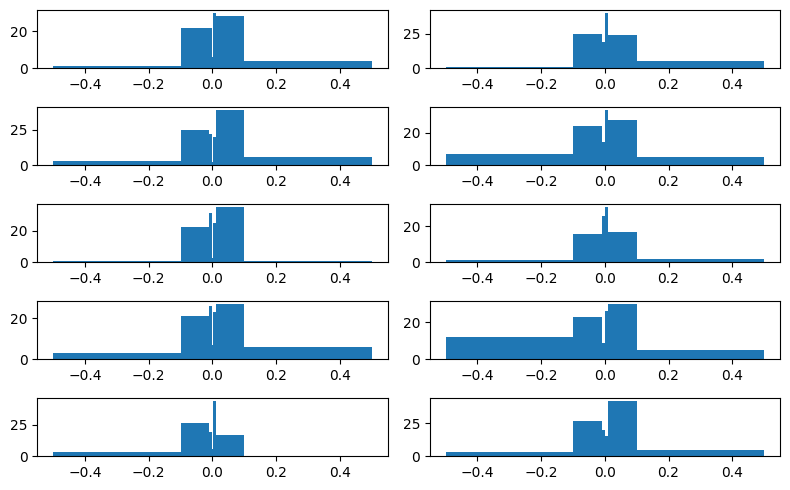

In [61]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(8, 5))

# Iterate through I values and plot histograms
for i, ax in enumerate(axs.flat):
    data = list(weights_dict[16][i].values())
    hist, edges = np.histogram(data, bins=bin_edges)
    
    
    ax.bar(edges[:-1], hist, width=np.diff(edges), align='edge')
   
plt.tight_layout()
plt.show()

In [ ]:
i